<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Empirical Path Loss Models Comparison 
</p>

#### Import of libraries used

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#### Load the cleaned data into `df` and inspect

In [5]:
df = pd.read_csv('../all_data_files/cleaned_dataset_per_device.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322171 entries, 0 to 1322170
Data columns (total 20 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   time         1322171 non-null  object 
 1   device_id    1322171 non-null  object 
 2   co2          1322171 non-null  float64
 3   humidity     1322171 non-null  float64
 4   pm25         1322171 non-null  float64
 5   pressure     1322171 non-null  float64
 6   temperature  1322171 non-null  float64
 7   rssi         1322171 non-null  float64
 8   snr          1322171 non-null  float64
 9   SF           1322171 non-null  int64  
 10  frequency    1322171 non-null  float64
 11  f_count      1322171 non-null  float64
 12  p_count      1322171 non-null  float64
 13  toa          1322171 non-null  float64
 14  distance     1322171 non-null  int64  
 15  c_walls      1322171 non-null  int64  
 16  w_walls      1322171 non-null  int64  
 17  exp_pl       1322171 non-null  float64
 18  n_

#### Compute and plot average exp_pl vs. distance

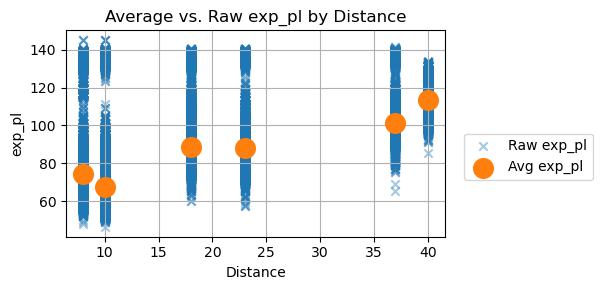

In [7]:
# Group by distance and take the mean of exp_pl
avg_exp_pl = df.groupby('distance')['exp_pl'].mean().reset_index()

# Create figure/axes
fig, ax = plt.subplots(figsize=(6, 3))

# 1) Raw points underneath
ax.scatter(df['distance'], df['exp_pl'], marker='x', alpha=0.4, label='Raw exp_pl', zorder=1)

# 2) Averages on top
ax.scatter(avg_exp_pl['distance'], avg_exp_pl['exp_pl'],  marker='o', s=200, label='Avg exp_pl', zorder=2)

# Labels and title
ax.set_xlabel('Distance')
ax.set_ylabel('exp_pl')
ax.set_title('Average vs. Raw exp_pl by Distance')

# Legend outside right
ax.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left', borderaxespad=0.)

# Improving legend layout
plt.tight_layout()
plt.subplots_adjust(right=0.75)

plt.grid(True)
plt.show()

### Baseline: FSPL at 868 MHz vs. Averaged Path-Loss

We use the free-space reference model at a fixed, representative frequency  
$$
L_{\mathrm{FS}}(d)
=20\log_{10}\!\Bigl(\frac{4\pi\,d\,f_0}{c}\Bigr),
$$
with  
- $c = 3\times10^8\ \mathrm{m/s}$  
- $f_0 = 868\ \mathrm{MHz}$.  

At $d = 1\ \mathrm{m}$ this gives  
$$
L_{\mathrm{FS}}(1)
=20\log_{10}\!\Bigl(\frac{4\pi\cdot1\cdot868\times10^6}{3\times10^8}\Bigr)
\approx 32\ \mathrm{dB}.
$$

Let  
- $\overline{L}(d_i)$ be the **averaged** measured path-loss at distance $d_i$,  
- $\hat L_i = L_{\mathrm{FS}}(d_i)$ the model prediction.  

We quantify the baseline fit by  
$$
\mathrm{RMSE}
=\sqrt{\frac{1}{N}\sum_{i=1}^N\bigl(\overline{L}(d_i)-\hat L_i\bigr)^2},
\quad
R^2
=1 - \frac{\sum_{i=1}^N\bigl(\overline{L}(d_i)-\hat L_i\bigr)^2}
               {\sum_{i=1}^N\bigl(\overline{L}(d_i)-\bar L\bigr)^2},
$$
where $\bar L = \frac{1}{N}\sum_{i=1}^N \overline{L}(d_i)\,$.

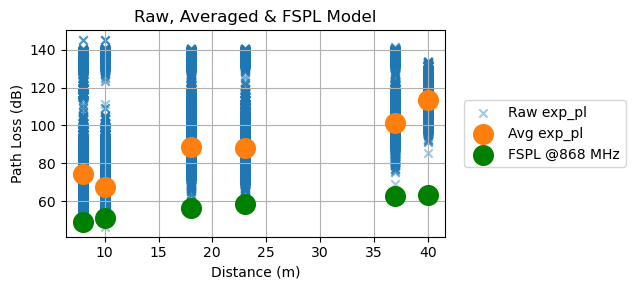


Baseline FSPL @868 MHz → RMSE = 33.78 dB,  R² = -3.819



In [9]:
# Constants and FSPL function at fixed f0=868 MHz
c, f0 = 3e8, 868e6  # speed of light (m/s), frequency (Hz)
def fspl_fixed(d): return 20 * np.log10(4 * np.pi * d * f0 / c)

# Prepare arrays for averaged points
d      = avg_exp_pl['distance'].values   # distances in m
y_obs  = avg_exp_pl['exp_pl'].values      # measured averages in dB
y_pred = fspl_fixed(d)                    # FSPL predictions

# Create figure/axes
fig, ax = plt.subplots(figsize=(6, 3))

# 1) Raw points underneath
ax.scatter(df['distance'], df['exp_pl'], marker='x', alpha=0.4, label='Raw exp_pl', zorder=1)
# 2) Averages on top
ax.scatter(avg_exp_pl['distance'], avg_exp_pl['exp_pl'], marker='o', s=200, label='Avg exp_pl', zorder=2)
# 3) FSPL model as scatter
ax.scatter(d, y_pred, marker='o', s=200, color='green', label='FSPL @868 MHz', zorder=3)

# Labels and title
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Path Loss (dB)')
ax.set_title('Raw, Averaged & FSPL Model')

# Legend outside right
ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

# Improving layout to fit legend
plt.tight_layout()
plt.subplots_adjust(right=0.75)

plt.grid(True)
plt.show()

# Compute RMSE and R² on the averaged points
rmse = np.sqrt(mean_squared_error(y_obs, y_pred))
r2   = r2_score(y_obs, y_pred)
print(f"\nBaseline FSPL @868 MHz → RMSE = {rmse:.2f} dB,  R² = {r2:.3f}\n")

### Floating-Intercept Log-Distance Model

We extend the FSPL baseline with a fitted, one-slope model at reference distance $(d_0 = 1)$ m:

$$
L(d) = b_0 + 10\,n\,\log_{10}\!\bigl(\tfrac{d}{d_0}\bigr) + X_\sigma,
$$

where  
- $b_0$ is the fitted close-in reference loss (dB),  
- $n$ is the path-loss exponent,  
- $X_\sigma \sim \mathcal{N}(0,\sigma^2)$ captures shadow fading.  


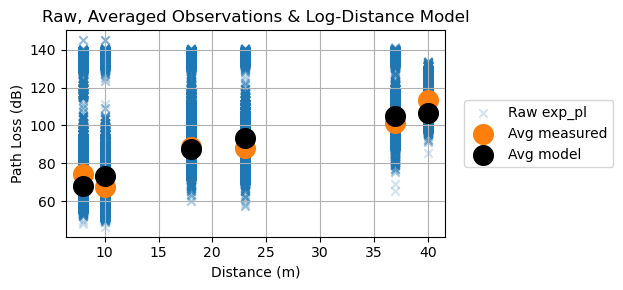


Fitted offset b0 = 18.01 dB (FSPL@1m≈32 dB), n = 5.53
Log-distance fit → RMSE = 12.22 dB, R² = 0.586



In [11]:
# Fit floating-intercept log-distance on raw samples
d0 = 1.0
X_raw = np.log10(df['distance'].values.reshape(-1,1) / d0)
y_raw = df['exp_pl'].values

model = LinearRegression(fit_intercept=True).fit(X_raw, y_raw)
b0, b1 = model.intercept_, model.coef_[0]
n_hat = b1 / 10.0

# Predict on raw and compute metrics
df['y_pred'] = model.predict(X_raw)
rmse_raw = np.sqrt(mean_squared_error(y_raw, df['y_pred']))
r2_raw   = r2_score(y_raw, df['y_pred'])

# Average measured and predicted by distance
avg_obs  = df.groupby('distance',   as_index=False)['exp_pl'].mean()
avg_pred = df.groupby('distance',   as_index=False)['y_pred'].mean()

# Plot raw, averaged observations, averaged predictions
fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter(df['distance'], df['exp_pl'],        marker='x', alpha=0.2, label='Raw exp_pl', zorder=1)
ax.scatter(avg_obs['distance'], avg_obs['exp_pl'], marker='o', s=200, label='Avg measured', zorder=2)
ax.scatter(avg_pred['distance'], avg_pred['y_pred'], marker='o', s=200, color='black', label='Avg model', zorder=3)

ax.set_xlabel('Distance (m)')
ax.set_ylabel('Path Loss (dB)')
ax.set_title('Raw, Averaged Observations & Log-Distance Model')
ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.grid(True)
plt.show()

# Print fitted parameters and metrics
print(f"\nFitted offset b0 = {b0:.2f} dB (FSPL@1m≈32 dB), n = {n_hat:.2f}")
print(f"Log-distance fit → RMSE = {rmse_raw:.2f} dB, R² = {r2_raw:.3f}\n")

### COST 231 Multi-Wall Model (No Floor Losses)

We apply a simplified version of the COST 231 model using only wall-based attenuation:

$$
L(d) = L_{1} + N \log_{10}(d) + N_c L_c + N_w L_w,
$$

where  
- $L_1$ is the fitted reference loss at $1\,\mathrm{m}$ (dB),  
- $N$ is the empirical distance-loss slope (dB/decade),  
- $N_c$ and $N_w$ are the number of **concrete** and **wood/glass** walls, respectively,  
- $L_c$ and $L_w$ are the learned attenuation factors per wall type.

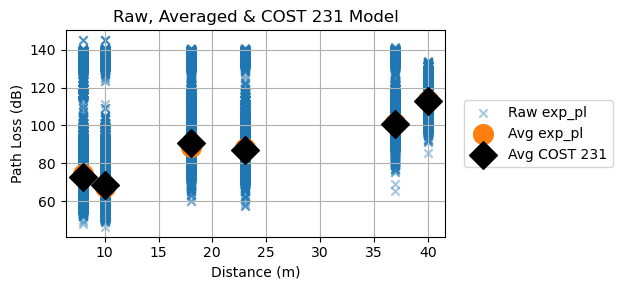


COST 231 fit → L1 = 27.81 dB, N = 40.82, L_c = 8.13 dB, L_w = 1.84 dB
RMSE = 11.13 dB, R² = 0.657



In [13]:
#  Compute log-distance and build predictors
df['log_d'] = np.log10(df['distance'])

#  Prepare design matrix and target
X = df[['log_d', 'c_walls', 'w_walls']].values
y = df['exp_pl'].values

# Fit COST 231-style linear model
model = LinearRegression(fit_intercept=True).fit(X, y)
L1 = model.intercept_
N, Lc, Lw = model.coef_

#  Predict and evaluate
df['y_pred_cost231'] = model.predict(X)
rmse_c231 = np.sqrt(mean_squared_error(y, df['y_pred_cost231']))
r2_c231   = r2_score(y, df['y_pred_cost231'])

#  Average measured and predicted values by distance
avg_exp_pl     = df.groupby('distance', as_index=False)['exp_pl'].mean()
avg_pred_cost  = df.groupby('distance', as_index=False)['y_pred_cost231'].mean()

# 6. Plot: raw, averaged measurements, and model predictions
fig, ax = plt.subplots(figsize=(6, 3))

# Raw
ax.scatter(df['distance'], df['exp_pl'], marker='x', alpha=0.4, label='Raw exp_pl', zorder=1)

# Avg observed
ax.scatter(avg_exp_pl['distance'], avg_exp_pl['exp_pl'], marker='o', s=200, label='Avg exp_pl', zorder=2)

# Avg predicted (COST 231)
ax.scatter(avg_pred_cost['distance'], avg_pred_cost['y_pred_cost231'], marker='D', s=200, color='black', label='Avg COST 231', zorder=3)

# Labels and formatting
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Path Loss (dB)')
ax.set_title('Raw, Averaged & COST 231 Model')

# Legend outside
ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.grid(True)
plt.show()

print(f"\nCOST 231 fit → L1 = {L1:.2f} dB, N = {N:.2f}, L_c = {Lc:.2f} dB, L_w = {Lw:.2f} dB")
print(f"RMSE = {rmse_c231:.2f} dB, R² = {r2_c231:.3f}\n")

### ITU-R P.1238 Indoor Propagation Model

We evaluate the path loss using the ITU-R P.1238 site-general formulation:

$$
L_{\mathrm{ITU}}(d) = 20\log_{10}(f) + N\log_{10}(d) + P_f(n_f) - 28,
$$

where  
- $f$ is the frequency in MHz,  
- $d$ is the distance in meters,  
- $N$ is the distance-loss exponent (empirically fitted),  
- $P_f(n_f)$ is the floor penetration loss (in dB),  
- the constant $-28$ aligns the model to $0\,\mathrm{dB}$ at $f = 1\,\mathrm{MHz}$ and $d = 1\,\mathrm{m}$.

In our case, $P_f(n_f) = 0$ since all devices are on the same floor.

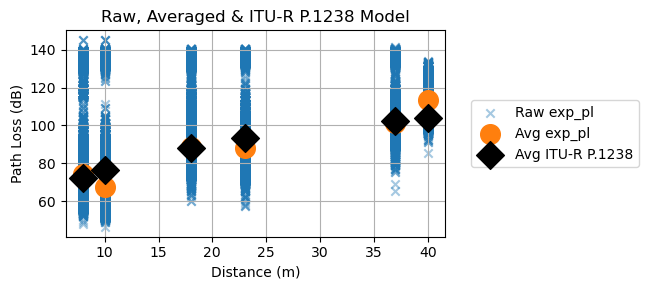

ITU-R P.1238 fit → N = 45.81 dB/decade
RMSE = 12.49 dB, R² = 0.568


In [15]:
# Constants
f = df['frequency']  # MHz
a_fixed = 20 * np.log10(f) - 28  # frequency-dependent constant

# Add log-distance column
df['log_d'] = np.log10(df['distance'])

# Fit model: L(d) = a_fixed + N * log10(d)
X = df[['log_d']].values
y = df['exp_pl'].values - a_fixed 
model = LinearRegression(fit_intercept=False).fit(X, y)
N_hat = model.coef_[0]

# Full model prediction
df['y_pred_itu'] = a_fixed + N_hat * df['log_d']
avg_exp_pl = df.groupby('distance', as_index=False)['exp_pl'].mean()
avg_pred_itu = df.groupby('distance', as_index=False)['y_pred_itu'].mean()

# Plotting
fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter(df['distance'], df['exp_pl'], marker='x', alpha=0.4, label='Raw exp_pl', zorder=1)
ax.scatter(avg_exp_pl['distance'], avg_exp_pl['exp_pl'], marker='o', s=200, label='Avg exp_pl', zorder=2)
ax.scatter(avg_pred_itu['distance'], avg_pred_itu['y_pred_itu'], marker='D', s=200, color='black', label='Avg ITU-R P.1238', zorder=3)
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Path Loss (dB)')
ax.set_title('Raw, Averaged & ITU-R P.1238 Model')
ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.grid(True)
plt.show()

# Compute and print evaluation metrics
rmse_itu = np.sqrt(mean_squared_error(df['exp_pl'], df['y_pred_itu']))
r2_itu = r2_score(df['exp_pl'], df['y_pred_itu'])

print(f"ITU-R P.1238 fit → N = {N_hat:.2f} dB/decade")
print(f"RMSE = {rmse_itu:.2f} dB, R² = {r2_itu:.3f}")